# Implementation of SVMs using CRNs

The following network demonstrates an SVM implemented using CRNs.

In [28]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

We first generate a dummy dataset (X as input is 2D and y is 1D). We now run the SVM model from the sklearn library to demonstrate the optimal weights and visualise the separation.

Accuracy of the SVM model: 100.00%
Weights (coefficients): [0.86494136 1.00987103]
Bias (intercept): -0.8202402772584444


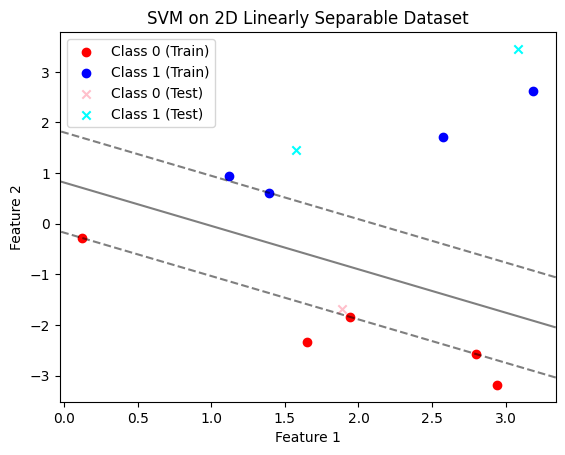

In [29]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 1: Generate the 2D linearly separable dataset
X, y = make_classification(n_samples=12, 
                           n_features=2, 
                           n_informative=2, 
                           n_redundant=0, 
                           n_clusters_per_class=1, 
                           class_sep=2, 
                           random_state=42)

# Step 2: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Step 3: Train an SVM model on the training data
svm_model = SVC(kernel='linear')  # Use a linear kernel since the data is linearly separable
svm_model.fit(X_train, y_train)

# Step 4: Make predictions on the test data
y_pred = svm_model.predict(X_test)

# Step 5: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the SVM model: {accuracy * 100:.2f}%")

# Access the weights (coefficients) and bias (intercept)
weights = svm_model.coef_[0]  # For linear SVM, this is a 1D array
bias = svm_model.intercept_[0]

# Print the weights and bias
print(f"Weights (coefficients): {weights}")
print(f"Bias (intercept): {bias}")

# Step 6: Visualize the decision boundary
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='red', label='Class 0 (Train)')
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='blue', label='Class 1 (Train)')
plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], color='pink', label='Class 0 (Test)', marker='x')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], color='cyan', label='Class 1 (Test)', marker='x')

# Plot the decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svm_model.decision_function(xy).reshape(XX.shape)

# Plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

plt.title("SVM on 2D Linearly Separable Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


In [30]:

X = np.array([[1, 7], [2, 8], [3, 8], [5, 1], [6, -1], [7, 3]])
y = np.array([1, 1, 1, -1, -1, -1])

To implement SVM using CRN, we have various helper functions like:

In [31]:
# oscillator wrapper function 
# takes in an array of oscillating species names, array of doped species, current timestep

def oscillator_function(y,t,num_oscillating_species):
    # making the array of the oscillating species
    oscillating_species = y[0:num_oscillating_species]
    doped_species = y[num_oscillating_species:]

    num_doped_species = len(doped_species)

    # initialisinng the derivatives
    d_oscillating_species = np.zeros(num_oscillating_species)
    d_doped_species = np.zeros(num_doped_species)

    # defining the derivatives 

    # for the oscillating species
    d_oscillating_species[0] = -oscillating_species[0]*oscillating_species[1] + oscillating_species[num_oscillating_species-1]*oscillating_species[0] + doped_species[0]*oscillating_species[num_oscillating_species-1] - doped_species[1]*oscillating_species[0]

    for idx in range(1,num_oscillating_species-1):
        d_oscillating_species[idx] = oscillating_species[idx-1]*oscillating_species[idx] - oscillating_species[idx+1]*oscillating_species[idx] + doped_species[idx]*oscillating_species[idx-1] - doped_species[idx+1]*oscillating_species[idx]
    
    d_oscillating_species[num_oscillating_species-1] = oscillating_species[num_oscillating_species-2]*oscillating_species[num_oscillating_species-1] - oscillating_species[0]*oscillating_species[num_oscillating_species-1] + doped_species[num_doped_species-1]*oscillating_species[num_oscillating_species-2] - doped_species[0]*oscillating_species[num_oscillating_species-1]

    # for the doped species
    d_doped_species[0] = -doped_species[0]*oscillating_species[num_doped_species-1]

    for idx in range(1,num_doped_species):
        d_doped_species[idx] = -doped_species[idx]*oscillating_species[idx-1]
    
    dydt = []
    dydt.extend(d_oscillating_species)
    dydt.extend(d_doped_species)
    
    return dydt

def oscillator_wrapper(oscillating_species, doped_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    
    # making an array of the species concentrations at timestep: current_timestep - 1
    oscillating_species_concentrations = np.array([species_concentrations[species][current_timestep - 1] for species in oscillating_species])
    doped_species_concentrations = np.array([species_concentrations[species][current_timestep - 1] for species in doped_species])

    # number of oscillating species 
    num_oscillating_species = len(oscillating_species_concentrations)

    # making the input array for the oscillator function
    y_0 = []
    y_0.extend(oscillating_species_concentrations)
    y_0.extend(doped_species_concentrations)

    # calculating the time range
    t = np.linspace(current_timestep - 1, current_timestep, 2) # 2 steps

    # solving the ODE
    sol = odeint(oscillator_function, y_0, t, args=(num_oscillating_species,))

    # review if you wanna add threshold
    # updating the species concentrations in current timestep
    for idx, species in enumerate(oscillating_species):
        species_concentrations_current_timestep[species] = sol[1][idx]

    for idx, species in enumerate(doped_species):
        species_concentrations_current_timestep[species] = sol[1][num_oscillating_species + idx]

    return species_concentrations_current_timestep

In [32]:
# laoding function
def load_function(y,t,a, o):
    c = y[0]
    dc_dt = -c*o + a*o
    return [ dc_dt]

def load_wrapper(from_species, to_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    # getting the species concentrations at current timestep - 1
    from_species_concentration = species_concentrations[from_species][current_timestep - 1]
    to_species_concentration = species_concentrations[to_species][current_timestep - 1]
    regulating_species_concentration = species_concentrations[regulating_species][current_timestep - 1]

    y0 = [to_species_concentration]
    t = np.linspace(current_timestep - 1, current_timestep, 2) # 2 steps
    
    sol = odeint(load_function, y0, t, args=(from_species_concentration, regulating_species_concentration))

    threshold_loading = 1e-4

    if np.abs(sol[1][0] - to_species_concentration) > threshold_loading: # to ensure update only happens when substantial #review
        species_concentrations_current_timestep[to_species] = sol[1][0] # only value of to_species is updated

    return species_concentrations_current_timestep



In [33]:
# multiplication function
def product_f(y,t,multiplicand_species_concentrations,o):
    c = y[0]

    dc_dt = 0

    temp = 1
    for idx, multiplicand in enumerate(multiplicand_species_concentrations):
        temp  = temp * multiplicand
    
    dc_dt = -c*o + temp*o
    return [ dc_dt]

def product_wrapper(multiplicand_species, product,regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    multiplicand_species_concentrations = np.array([species_concentrations[species][current_timestep - 1] for species in multiplicand_species])

    c = species_concentrations[product][current_timestep - 1]
    o = species_concentrations[regulating_species][current_timestep - 1]

    y0 = [c]
    t = np.linspace(current_timestep-1, current_timestep,2)
    
    sol = odeint(product_f, y0, t, args=(multiplicand_species_concentrations, o))

    threshold_product = 1e-4

    if np.abs(c-sol[1][0])> threshold_product:
        species_concentrations_current_timestep[product] = sol[1][0]
      
    return species_concentrations_current_timestep

In [34]:
# sum function
def sum_f(y,t,additive_species_concentrations,o):
    c = y[0]
    temp =0
    for idx, additive in enumerate(additive_species_concentrations):
        temp = temp + additive
    dc_dt = -c*o + temp*o
    return [ dc_dt]

def sum_wrapper(additive_species, sum, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    # getting the species concentrations at current timestep -1
    additive_species_concentrations =  np.array([species_concentrations[species][current_timestep - 1] for species in additive_species])

    c = species_concentrations[sum][current_timestep-1]
    o = species_concentrations[regulating_species][current_timestep-1]

    y0 = [c]
    t = np.linspace(current_timestep-1, current_timestep,2)
    
    sol = odeint(sum_f, y0, t, args=(additive_species_concentrations,o))

    threshold_sum = 1e-4

    if np.abs(c-sol[1][0]) > threshold_sum:
        species_concentrations_current_timestep[sum] = sol[1][0]

    return species_concentrations_current_timestep

In [35]:
# mapping function for comparison
def comparison_f(y, t, a, b, o):
    dydt = []
    bgta = y[0]
    blta = y[1]

    temp = b*blta*o - bgta*a*o
    dydt.append(temp)

    temp = bgta*a*o - b*blta*o
    dydt.append(temp)

    return dydt

def comparison_wrapper(species_a,species_b, b_gt_a, b_lt_a, regulating_species , current_timestep, species_concentrations, species_concentrations_current_timestep):

    a = species_concentrations[species_a][current_timestep-1]
    b = species_concentrations[species_b][current_timestep-1]
    bgta = species_concentrations[b_gt_a][current_timestep-1]
    blta = species_concentrations[b_lt_a][current_timestep-1]
    o = species_concentrations[regulating_species][current_timestep-1]

    y0 = [bgta, blta]
    t = np.linspace(current_timestep -1, current_timestep, 2)
    
    sol = odeint(comparison_f, y0, t, args=(a,b, o))

    threshold_comparison = 1e-4

    if np.abs(bgta-sol[:,0][-1]) > threshold_comparison:
        species_concentrations_current_timestep[b_gt_a] = sol[:, 0][-1]
    if np.abs(blta-sol[:,1][-1]) > threshold_comparison:
        species_concentrations_current_timestep[b_lt_a] = sol[:, 1][-1]

    return species_concentrations_current_timestep


In [36]:
# approximate majority for comparison
def approx_majority_f(y, t, o):
    kgtq = y[0]
    kltq = y[1]
    b_help = y[2]

    dydt = []
    
    temp =  - kgtq*kltq*o + kgtq *b_help*o
    dydt.append(temp)

    temp = kltq*b_help*o - kgtq*kltq*o
    dydt.append(temp)

    temp = 2* kgtq*kltq*o - kgtq*b_help*o - kltq*b_help*o
    dydt.append(temp)

    return dydt

def approx_majority_wrapper(b_gt_a, b_lt_a, helper_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    bgta = species_concentrations[b_gt_a][current_timestep-1]
    blta = species_concentrations[b_lt_a][current_timestep-1]
    helper_s = species_concentrations[helper_species][current_timestep-1]
    o = species_concentrations[regulating_species][current_timestep-1]

    y_0 = [bgta, blta, helper_s]

    t = np.linspace(current_timestep, current_timestep+1, 2)

    sol = odeint(approx_majority_f, y_0, t, args=(o,))

    threshold_am = 1e-4

    if np.abs(bgta-sol[:,0][-1]) > threshold_am:
        species_concentrations_current_timestep[b_gt_a] = sol[:, 0][-1]
    if np.abs(blta-sol[:,1][-1]) > threshold_am:
        species_concentrations_current_timestep[b_lt_a] = sol[:, 1][-1]
    if np.abs(helper_s - sol[:,2][-1]) > threshold_am:
        species_concentrations_current_timestep[helper_species] = sol[:,2][-1]

    return species_concentrations_current_timestep


In [37]:
# w_x = w*x module

# takes in arrays containing strings of the name of the species 
def product_wx(weights_array, x_array, product_array, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    num_indices = len(weights_array)
    for i in range(num_indices):
        species_concentrations_current_timestep = product_wrapper([weights_array[i] , x_array[i]] , product_array[i] , regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)
    return species_concentrations_current_timestep


In [38]:
# summation of species

# takes in arrays containing strings of name of species
def summation_wx_b(additive_array, sum_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    
    species_concentrations_current_timestep = sum_wrapper(additive_array, sum_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep
    

In [39]:
# Q = YP

def yp(yp, y,p,regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    for i in range(4):
        species_concentrations_current_timestep = product_wrapper([y[i],p[i]], yp[i], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)


    return species_concentrations_current_timestep


In [40]:
# Q+ & Q- . q[0] is for Q+ and q[1] is for Q- + K ( K is 1 here)

def q(q, yp, K ,regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    species_concentrations_current_timestep = sum_wrapper([yp[0],yp[1]], q[0], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = sum_wrapper([yp[2],yp[3],K], q[1], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep

In [41]:
#  comparing Q+ and Q- +1. we are really comparing Q+ and (Q- + K) where K is 1. if qgtk > qltk Q+ > Q- +1. if qgtk < qltk Q+ < Q- +1
def comparing_q(q, qgtk, qltk, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    
    species_concentrations_current_timestep = comparison_wrapper(q[1],q[0], qgtk, qltk, regulating_species , current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep

In [42]:
# applying approximate majority

def q_am(qgtk, qltk, helper_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    species_concentrations_current_timestep = approx_majority_wrapper(qgtk, qltk, helper_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep


In [43]:
def calculate_update_weights(weights, x_array, y_array, cost_always, cost_classification_1, cost_classification_2,  regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    lr = 'lr'
    const_temp  = 'ct'
    l = len(weights)

    for i in range(l):
        species_concentrations_current_timestep = product_wrapper([lr, const_temp, weights[int((len(weights) /2  + i )%len(weights))]], cost_always[i], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)
        species_concentrations_current_timestep = product_wrapper([lr, x_array[i], 'Q_gt_K', y_array[0] ], cost_classification_1[i], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)
        species_concentrations_current_timestep = product_wrapper([lr, x_array[int((len(x_array) /2  + i )%len(x_array))], 'Q_gt_K', y_array[1] ], cost_classification_2[i], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)

        
    return species_concentrations_current_timestep

In [44]:
def update_weights(weights, final_weights , cost_always, cost_classification_1, cost_classification_2, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    l = len(weights)

    for i in range(l):
        species_concentrations_current_timestep = sum_wrapper([weights[i], cost_always[i], cost_classification_1[i] , cost_classification_2[i]], final_weights[i], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)
        
    return species_concentrations_current_timestep

In [45]:
# some variables
d = 10**(-10)
p = 6
p_tilda = 2
total = [1,2,3,4,5,6]
i1 = [1,3]
i2 = [2,4]

lr = 0.0001
epochs = 30
ct = 2/1000

In [46]:
X_train = X
y_train = y

In [47]:

for i in range(len(y_train)):
    if y_train[i] == 0:
        y_train[i] = -1

In [48]:
print(X_train)
print(y_train)

[[ 1  7]
 [ 2  8]
 [ 3  8]
 [ 5  1]
 [ 6 -1]
 [ 7  3]]
[ 1  1  1 -1 -1 -1]


In [49]:
def p_f(x):
    if (x>= 0):
        return x
    else:
        return 0

def n_f(x):
    if (x<0):
        return -x
    else:
        return 0

In [50]:

species_concentrations = {
    'o1' : [1],
    'o2' : [0],
    'o3' : [0],
    'o4' : [0],
    'o5' : [0],
    'o6' : [0],
    'o7' : [0],
    'o8' : [0],
    'o9' : [0],
    'o10' : [0],
    'o11' : [0],
    'o12' : [0],


    'd1' : [d],
    'd2' : [d],
    'd3' : [d],
    'd4' : [d],
    'd5' : [d],
    'd6' : [d],
    'd7' : [d],
    'd8' : [d],
    'd9' : [d],
    'd10' : [d],
    'd11' : [d],
    'd12' : [d],


    # x_i
    'x1_p': [p_f(X_train[0][0])],
    'x2_p': [p_f(X_train[0][1])],
    'x3_p': [p_f(X_train[1][0])],
    'x4_p': [p_f(X_train[1][1])], # x3 onwards, take modulo 3 to get the correct value. answer represents dimension and quotient + 1 is the number
    'x5_p': [p_f(X_train[2][0])],
    'x6_p': [p_f(X_train[2][1])],

    # c_l_i (l row, i column)
    'c_1_1_p': [1],
    'c_1_2_p': [0],
    'c_1_3_p': [0],
    'c_1_4_p': [0],
    'c_1_5_p': [0],
    'c_1_6_p': [0],
    'c_2_1_p': [0],
    'c_2_2_p': [1],
    'c_2_3_p': [0],
    'c_2_4_p': [0],
    'c_2_5_p': [0],
    'c_2_6_p': [0],

    # s_l, act as input species
    's_1_p': [0],
    's_2_p': [0],

    # c tilda
    'c~_1_1_p': [0],
    'c~_1_2_p': [0],
    'c~_1_3_p': [0],
    'c~_1_4_p': [0],
    'c~_1_5_p': [0],
    'c~_1_6_p': [0],
    'c~_2_1_p': [0],
    'c~_2_2_p': [0],
    'c~_2_3_p': [0],
    'c~_2_4_p': [0],
    'c~_2_5_p': [0],
    'c~_2_6_p': [0],

    # x_i_c_l_i
    'x1_c_1_1_p': [0],
    'x2_c_1_2_p': [0],
    'x3_c_1_3_p': [0],
    'x4_c_1_4_p': [0],
    'x5_c_1_5_p': [0],
    'x6_c_1_6_p': [0],

    'x1_c_2_1_p': [0],
    'x2_c_2_2_p': [0],
    'x3_c_2_3_p': [0],
    'x4_c_2_4_p': [0],
    'x5_c_2_5_p': [0],
    'x6_c_2_6_p': [0],   

    # x_i
    'x1_n': [n_f(X_train[0][0])],
    'x2_n': [n_f(X_train[0][1])],
    'x3_n': [n_f(X_train[1][0])],
    'x4_n': [n_f(X_train[1][1])], # x4 onwards, take modulo 3 to get the correct value. it represents 2 dimension
    'x5_n': [n_f(X_train[2][0])],
    'x6_n': [n_f(X_train[2][1])],

    # c_l_i (l row, i column)
    'c_1_1_n': [1],
    'c_1_2_n': [0],
    'c_1_3_n': [0],
    'c_1_4_n': [0],
    'c_1_5_n': [0],
    'c_1_6_n': [0],
    'c_2_1_n': [0],
    'c_2_2_n': [1],
    'c_2_3_n': [0],
    'c_2_4_n': [0],
    'c_2_5_n': [0],
    'c_2_6_n': [0],

    # s_l
    's_1_n': [0],
    's_2_n': [0],

    # c tilda
    'c~_1_1_n': [0],
    'c~_1_2_n': [0],
    'c~_1_3_n': [0],
    'c~_1_4_n': [0],
    'c~_1_5_n': [0],
    'c~_1_6_n': [0],
    'c~_2_1_n': [0],
    'c~_2_2_n': [0],
    'c~_2_3_n': [0],
    'c~_2_4_n': [0],
    'c~_2_5_n': [0],
    'c~_2_6_n': [0],

    # x_i_c_l_i
    'x1_c_1_1_n': [0],
    'x2_c_1_2_n': [0],
    'x3_c_1_3_n': [0],
    'x4_c_1_4_n': [0],
    'x5_c_1_5_n': [0],
    'x6_c_1_6_n': [0],

    'x1_c_2_1_n': [0],
    'x2_c_2_2_n': [0],
    'x3_c_2_3_n': [0],
    'x4_c_2_4_n': [0],
    'x5_c_2_5_n': [0],
    'x6_c_2_6_n': [0],

    # # y

    # y_i
    'y1_p': [p_f(y_train[0])],
    'y1_n': [n_f(y_train[0])],
    'y2_p': [p_f(y_train[1])],
    'y2_n': [n_f(y_train[1])],
    'y3_p': [p_f(y_train[2])],
    'y3_n': [n_f(y_train[2])],

    # c_l_i (l row, i column)
    'c_1_1_y': [1],
    'c_1_2_y': [0],
    'c_1_3_y': [0],
    'c_1_4_y': [0],
    'c_1_5_y': [0],
    'c_1_6_y': [0],
    'c_2_1_y': [0],
    'c_2_2_y': [1],
    'c_2_3_y': [0],
    'c_2_4_y': [0],
    'c_2_5_y': [0],
    'c_2_6_y': [0],


    # c tilda
    'c~_1_1_y': [0],
    'c~_1_2_y': [0],
    'c~_1_3_y': [0],
    'c~_1_4_y': [0],
    'c~_1_5_y': [0],
    'c~_1_6_y': [0],
    'c~_2_1_y': [0],
    'c~_2_2_y': [0],
    'c~_2_3_y': [0],
    'c~_2_4_y': [0],
    'c~_2_5_y': [0],
    'c~_2_6_y': [0],

    # x_i_c_l_i
    'x1_c_1_1_y': [0],
    'x2_c_1_2_y': [0],
    'x3_c_1_3_y': [0],
    'x4_c_1_4_y': [0],
    'x5_c_1_5_y': [0],
    'x6_c_1_6_y': [0],

    'x1_c_2_1_y': [0],
    'x2_c_2_2_y': [0],
    'x3_c_2_3_y': [0],
    'x4_c_2_4_y': [0],
    'x5_c_2_5_y': [0],
    'x6_c_2_6_y': [0],   










    # //////////////////////////////////////////////////

    'w1_p': [1], # w1 is 1
    'w2_p': [1], # w2 is 1
    'w1_n': [0],
    'w2_n': [0],

    # product species
    'w1px1p_p': [0],
    'w2px2p_p': [0],
    'w1nx1n_p': [0],
    'w2nx2n_p': [0],
    'w1px1n_n': [0],
    'w2px2n_n': [0],
    'w1nx1p_n': [0],
    'w2nx2p_n': [0],

        # bias species
    'b_p': [0],
    'b_n': [0],

        # sum species
    'P_p': [0],
    'P_n': [0],


    # output species
    'y_p': [0],
    'y_n': [0],

    # yp species
    'ypPp_p': [0],
    'ynPn_p': [0],
    'ypPn_n': [0],
    'ynPp_n': [0],
        # Q species
    'Q_p': [0],
    'Q_n+K': [0],

    # K species
    'K': [1], 

    # qgtk, qltk & helper species
    'Q_gt_K': [0.5],
    'Q_lt_K': [0.5],
    'helper': [0],

    # lr and ct
    'lr': [lr],
    'ct': [ct],

    # cost always species : lr*ct* species
    'lr_ct_w1_n': [0],
    'lr_ct_w2_n': [0],
    'lr_ct_w1_p': [0],
    'lr_ct_w2_p': [0],

        # cost classification 1 species : lr*species*Q_gt_K* y_p
    'lr_Q_gt_K_y_p_x1_p': [0],
    'lr_Q_gt_K_y_p_x2_p': [0],
    'lr_Q_gt_K_y_p_x1_n': [0],
    'lr_Q_gt_K_y_p_x2_n': [0],

     # cost classification 2 species : lr*species_complement*Q_gt_K* y_n
    'lr_Q_gt_K_y_n_x1_n': [0],
    'lr_Q_gt_K_y_n_x2_n': [0],
    'lr_Q_gt_K_y_n_x1_p': [0],
    'lr_Q_gt_K_y_n_x2_p': [0],

    # cost of bias update
    'lr_yn_Q_gt_K': [0],
    'lr_yp_Q_gt_K': [0],

    # final weights
    'w1_p_final': [0],
    'w2_p_final': [0],
    'w1_n_final': [0],
    'w2_n_final': [0],

    # final bias
    'b_p_final': [0],
    'b_n_final': [0],







}

In [51]:
oscillating_species_1 = [
    'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'o9', 'o10', 'o11', 'o12'
]

doped_species_1 = [
    'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12'
]

x_array_1_p = [
    'x1_p', 'x2_p', 'x3_p', 'x4_p', 'x5_p', 'x6_p'
]

c_array_1_p = [
    'c_1_1_p', 'c_1_2_p', 'c_1_3_p', 'c_1_4_p', 'c_1_5_p', 'c_1_6_p', 
]

s_array_1_p = [
    's_1_p', 's_2_p'
]

c_array_2_p = [
    'c_2_1_p', 'c_2_2_p', 'c_2_3_p', 'c_2_4_p', 'c_2_5_p', 'c_2_6_p', 
]

product_array_1_p = [
    'x1_c_1_1_p', 'x2_c_1_2_p', 'x3_c_1_3_p', 'x4_c_1_4_p', 'x5_c_1_5_p', 'x6_c_1_6_p',
]

product_array_2_p = [
    'x1_c_2_1_p', 'x2_c_2_2_p', 'x3_c_2_3_p', 'x4_c_2_4_p', 'x5_c_2_5_p', 'x6_c_2_6_p',
]

c_tilda_array_1_p = [
    'c~_1_1_p', 'c~_1_2_p', 'c~_1_3_p', 'c~_1_4_p', 'c~_1_5_p', 'c~_1_6_p', 
]

c_tilda_array_2_p = [
    'c~_2_1_p', 'c~_2_2_p', 'c~_2_3_p', 'c~_2_4_p', 'c~_2_5_p', 'c~_2_6_p', 
]

x_array_1_n = [
    'x1_n', 'x2_n', 'x3_n', 'x4_n', 'x5_n', 'x6_n'
]

c_array_1_n = [
    'c_1_1_n', 'c_1_2_n', 'c_1_3_n', 'c_1_4_n', 'c_1_5_n', 'c_1_6_n', 
]

s_array_1_n = [
    's_1_n', 's_2_n'
]

c_array_2_n = [
    'c_2_1_n', 'c_2_2_n', 'c_2_3_n', 'c_2_4_n', 'c_2_5_n', 'c_2_6_n', 
]

product_array_1_n = [
    'x1_c_1_1_n', 'x2_c_1_2_n', 'x3_c_1_3_n', 'x4_c_1_4_n', 'x5_c_1_5_n', 'x6_c_1_6_n',
]

product_array_2_n = [
    'x1_c_2_1_n', 'x2_c_2_2_n', 'x3_c_2_3_n', 'x4_c_2_4_n', 'x5_c_2_5_n', 'x6_c_2_6_n',
]

c_tilda_array_1_n = [
    'c~_1_1_n', 'c~_1_2_n', 'c~_1_3_n', 'c~_1_4_n', 'c~_1_5_n', 'c~_1_6_n', 
]

c_tilda_array_2_n = [
    'c~_2_1_n', 'c~_2_2_n', 'c~_2_3_n', 'c~_2_4_n', 'c~_2_5_n', 'c~_2_6_n', 
]

# y


x_array_1_y = [
    'y1_p', 'y1_n', 'y2_p', 'y2_n', 'y3_p', 'y3_n'
]

c_array_1_y = [
    'c_1_1_y', 'c_1_2_y', 'c_1_3_y', 'c_1_4_y', 'c_1_5_y', 'c_1_6_y', 
]

s_array_1_y = [
    'y_p', 'y_n'
]

c_array_2_y = [
    'c_2_1_y', 'c_2_2_y', 'c_2_3_y', 'c_2_4_y', 'c_2_5_y', 'c_2_6_y', 
]

product_array_1_y = [
    'x1_c_1_1_y', 'x2_c_1_2_y', 'x3_c_1_3_y', 'x4_c_1_4_y', 'x5_c_1_5_y', 'x6_c_1_6_y',
]

product_array_2_y = [
    'x1_c_2_1_y', 'x2_c_2_2_y', 'x3_c_2_3_y', 'x4_c_2_4_y', 'x5_c_2_5_y', 'x6_c_2_6_y',
]

c_tilda_array_1_y = [
    'c~_1_1_y', 'c~_1_2_y', 'c~_1_3_y', 'c~_1_4_y', 'c~_1_5_y', 'c~_1_6_y', 
]

c_tilda_array_2_y = [
    'c~_2_1_y', 'c~_2_2_y', 'c~_2_3_y', 'c~_2_4_y', 'c~_2_5_y', 'c~_2_6_y', 
]

# ////////////////////////////////////////////////////

weights_array = [
    'w1_p', 'w2_p', 'w1_n', 'w2_n'
]

x_array = [
    's_1_p', 's_2_p', 's_1_n', 's_2_n'
]

weights_array_2 = [
    'w1_p', 'w2_p',  'w1_n', 'w2_n' , 'w1_p', 'w2_p', 'w1_n', 'w2_n', 
]

x_array_2 = [
    'x1_p', 'x2_p',  'x1_n', 'x2_n',  'x1_n', 'x2_n', 'x1_p', 'x2_p'
]

product_array = [
    'w1px1p_p', 'w2px2p_p', 'w1nx1n_p', 'w2nx2n_p',  'w1px1n_n', 'w2px2n_n',  'w1nx1p_n', 'w2nx2p_n'
]

additive_array_p = [
    'w1px1p_p', 'w2px2p_p', 'w1nx1n_p', 'w2nx2n_p', 'b_p'
]

additive_array_n = [
    'w1px1n_n', 'w2px2n_n',  'w1nx1p_n', 'w2nx2p_n', 'b_n'
]

yp_array = [
    'ypPp_p', 'ynPn_p', 'ypPn_n', 'ynPp_n'
]

p_array = [
    'P_p', 'P_n' , 'P_n', 'P_p'
]

y_array = [
    'y_p', 'y_n'
]

y_array_2 = [
    'y_p', 'y_n', 'y_p', 'y_n'
]

q_array = [
    'Q_p', 'Q_n+K'
]

cost_always = [
    'lr_ct_w1_n', 'lr_ct_w2_n', 'lr_ct_w1_p', 'lr_ct_w2_p'
]

cost_classification_1 = [
    'lr_Q_gt_K_y_p_x1_p', 'lr_Q_gt_K_y_p_x2_p', 'lr_Q_gt_K_y_p_x1_n', 'lr_Q_gt_K_y_p_x2_n'
]


cost_classification_2 = [
    'lr_Q_gt_K_y_n_x1_n', 'lr_Q_gt_K_y_n_x2_n',  'lr_Q_gt_K_y_n_x1_p', 'lr_Q_gt_K_y_n_x2_p'
]

final_weights = [
    'w1_p_final', 'w2_p_final',  'w1_n_final', 'w2_n_final'
]

final_bias = [
    'b_p_final', 'b_n_final'
]




In [52]:
t_l1 = 100000

for t in range(1, t_l1):
    species_concentrations_current_timestep = {}

    # oscillate
    species_concentrations_current_timestep = oscillator_wrapper(oscillating_species_1, doped_species_1, t, species_concentrations, species_concentrations_current_timestep)
    
    # product cx
    species_concentrations_current_timestep = product_wx(c_array_1_p, x_array_1_p, product_array_1_p, 'o1', t, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = product_wx(c_array_2_p, x_array_1_p, product_array_2_p, 'o1', t, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = product_wx(c_array_1_n, x_array_1_n, product_array_1_n, 'o1', t, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = product_wx(c_array_2_n, x_array_1_n, product_array_2_n, 'o1', t, species_concentrations, species_concentrations_current_timestep)

    # y
    species_concentrations_current_timestep = product_wx(c_array_1_y, x_array_1_y, product_array_1_y, 'o1', t, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = product_wx(c_array_2_y, x_array_1_y, product_array_2_y, 'o1', t, species_concentrations, species_concentrations_current_timestep)

    species_concentrations_current_timestep = sum_wrapper(product_array_1_p, 's_1_p', 'o1', t, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = sum_wrapper(product_array_2_p, 's_2_p', 'o1', t, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = sum_wrapper(product_array_1_n, 's_1_n', 'o1', t, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = sum_wrapper(product_array_2_n, 's_2_n', 'o1', t, species_concentrations, species_concentrations_current_timestep)

    species_concentrations_current_timestep = sum_wrapper(product_array_1_y, 'y_p', 'o1', t, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = sum_wrapper(product_array_2_y, 'y_n', 'o1', t, species_concentrations, species_concentrations_current_timestep)


    # load c to c~
    for i in range(len(c_array_1_p)):
        species_concentrations_current_timestep = load_wrapper(c_array_1_p[i], c_tilda_array_1_p[i], 'o3', t, species_concentrations, species_concentrations_current_timestep)
    
    for i in range(len(c_array_2_p)):
        species_concentrations_current_timestep = load_wrapper(c_array_2_p[i], c_tilda_array_2_p[i], 'o3', t, species_concentrations, species_concentrations_current_timestep)

    for i in range(len(c_array_1_n)):
        species_concentrations_current_timestep = load_wrapper(c_array_1_n[i], c_tilda_array_1_n[i], 'o3', t, species_concentrations, species_concentrations_current_timestep)
    
    for i in range(len(c_array_2_n)):
        species_concentrations_current_timestep = load_wrapper(c_array_2_n[i], c_tilda_array_2_n[i], 'o3', t, species_concentrations, species_concentrations_current_timestep)

    for i in range(len(c_array_1_y)):
        species_concentrations_current_timestep = load_wrapper(c_array_1_y[i], c_tilda_array_1_y[i], 'o3', t, species_concentrations, species_concentrations_current_timestep)

    for i in range(len(c_array_2_y)):
        species_concentrations_current_timestep = load_wrapper(c_array_2_y[i], c_tilda_array_2_y[i], 'o3', t, species_concentrations, species_concentrations_current_timestep)
    
    
    # l=1
    # positive
    l = 1
    
    for o in i1:
        o = o-1 # 1 indexed
        species_concentrations_current_timestep = load_wrapper(c_tilda_array_1_p[o], c_array_1_p[o+p_tilda], 'o5', t, species_concentrations, species_concentrations_current_timestep)

    o = p-p_tilda + l
    o = o-1
    species_concentrations_current_timestep = load_wrapper(c_tilda_array_1_p[o], c_array_1_p[l-1], 'o5', t, species_concentrations, species_concentrations_current_timestep)

    j_arr = set(total) - set(i1) - set([p-p_tilda + l])
    j_arr = list(j_arr)

    for j in j_arr:
        j = j-1
        species_concentrations_current_timestep = load_wrapper(c_tilda_array_1_p[j], c_array_1_p[j], 'o5', t, species_concentrations, species_concentrations_current_timestep)

    # negative
    l = 1

    for o in i1:
        o = o-1
        species_concentrations_current_timestep = load_wrapper(c_tilda_array_1_n[o], c_array_1_n[o+p_tilda], 'o5', t, species_concentrations, species_concentrations_current_timestep)
    
    o = p-p_tilda + l
    o = o-1
    species_concentrations_current_timestep = load_wrapper(c_tilda_array_1_n[o], c_array_1_n[l-1], 'o5', t, species_concentrations, species_concentrations_current_timestep)

    j_arr = set(total) - set(i1) - set([p-p_tilda + l])
    j_arr = list(j_arr)

    for j in j_arr:
        j = j-1
        species_concentrations_current_timestep = load_wrapper(c_tilda_array_1_n[j], c_array_1_n[j], 'o5', t, species_concentrations, species_concentrations_current_timestep)


    
    # l = 2
    # positive
    l = 2
    for o in i2:
        o = o-1
        species_concentrations_current_timestep = load_wrapper(c_tilda_array_2_p[o], c_array_2_p[o+p_tilda], 'o5', t, species_concentrations, species_concentrations_current_timestep)

    o = p-p_tilda + l
    o = o-1
    species_concentrations_current_timestep = load_wrapper(c_tilda_array_2_p[o], c_array_2_p[l-1], 'o5', t, species_concentrations, species_concentrations_current_timestep)

    j_arr = set(total) - set(i2) - set([p-p_tilda + l])
    j_arr = list(j_arr)

    for j in j_arr:
        j = j-1
        species_concentrations_current_timestep = load_wrapper(c_tilda_array_2_p[j], c_array_2_p[j], 'o5', t, species_concentrations, species_concentrations_current_timestep)

    # negative
    l = 2
    for o in i2:
        o = o-1
        species_concentrations_current_timestep = load_wrapper(c_tilda_array_2_n[o], c_array_2_n[o+p_tilda], 'o5', t, species_concentrations, species_concentrations_current_timestep)
    
    o = p-p_tilda + l
    o = o-1
    species_concentrations_current_timestep = load_wrapper(c_tilda_array_2_n[o], c_array_2_n[l-1], 'o5', t, species_concentrations, species_concentrations_current_timestep)

    j_arr = set(total) - set(i2) - set([p-p_tilda + l])
    j_arr = list(j_arr)

    for j in j_arr:
        j = j-1
        species_concentrations_current_timestep = load_wrapper(c_tilda_array_2_n[j], c_array_2_n[j], 'o5', t, species_concentrations, species_concentrations_current_timestep)

    # y

    # l =1
    l = 1
    for o in i1:
        o = o-1
        species_concentrations_current_timestep = load_wrapper(c_tilda_array_1_y[o], c_array_1_y[o+p_tilda], 'o5', t, species_concentrations, species_concentrations_current_timestep)

    o = p-p_tilda + l
    o = o-1
    species_concentrations_current_timestep = load_wrapper(c_tilda_array_1_y[o], c_array_1_y[l-1], 'o5', t, species_concentrations, species_concentrations_current_timestep)

    j_arr = set(total) - set(i1) - set([p-p_tilda + l])
    j_arr = list(j_arr)

    for j in j_arr:
        j = j-1
        species_concentrations_current_timestep = load_wrapper(c_tilda_array_1_y[j], c_array_1_y[j], 'o5', t, species_concentrations, species_concentrations_current_timestep)
    
    # l = 2
    l = 2
    for o in i2:
        o = o-1
        species_concentrations_current_timestep = load_wrapper(c_tilda_array_2_y[o], c_array_2_y[o+p_tilda], 'o5', t, species_concentrations, species_concentrations_current_timestep)

    o = p-p_tilda + l
    o = o-1
    species_concentrations_current_timestep = load_wrapper(c_tilda_array_2_y[o], c_array_2_y[l-1], 'o5', t, species_concentrations, species_concentrations_current_timestep)

    j_arr = set(total) - set(i2) - set([p-p_tilda + l])
    j_arr = list(j_arr)

    for j in j_arr:
        j = j-1
        species_concentrations_current_timestep = load_wrapper(c_tilda_array_2_y[j], c_array_2_y[j], 'o5', t, species_concentrations, species_concentrations_current_timestep)
    

    


    # main network

    
        # product wx
    species_concentrations_current_timestep = product_wx(weights_array_2, x_array_2, product_array, 'o7', t, species_concentrations, species_concentrations_current_timestep)

    # sum wx + b = p
    species_concentrations_current_timestep = summation_wx_b(additive_array_p, 'P_p', 'o7', t, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = summation_wx_b(additive_array_n, 'P_n', 'o7', t, species_concentrations, species_concentrations_current_timestep)

    # yp
    species_concentrations_current_timestep = yp(yp_array, y_array_2, p_array, 'o7', t, species_concentrations, species_concentrations_current_timestep)

    # Q 
    species_concentrations_current_timestep = q(q_array, yp_array, 'K', 'o7', t, species_concentrations, species_concentrations_current_timestep)

    # Q+ - Q- > 1
    # comparing Q+ and Q- +1
    species_concentrations_current_timestep = comparing_q(q_array, 'Q_gt_K', 'Q_lt_K', 'o7', t, species_concentrations, species_concentrations_current_timestep)

    # applying approximate majority
    species_concentrations_current_timestep = q_am('Q_gt_K', 'Q_lt_K', 'helper', 'o9', t, species_concentrations, species_concentrations_current_timestep)

    # calculating the update weights
    species_concentrations_current_timestep = calculate_update_weights(weights_array, x_array, y_array, cost_always, cost_classification_1, cost_classification_2, 'o9', t, species_concentrations, species_concentrations_current_timestep)

    # calculating the update bias 
    # species_concentrations_current_timestep = product_wrapper(['lr', 'y_n', 'Q_gt_K'], 'lr_yn_Q_gt_K', 'o9', t, species_concentrations, species_concentrations_current_timestep)
    # species_concentrations_current_timestep = product_wrapper(['lr', 'y_p', 'Q_gt_K'], 'lr_yp_Q_gt_K', 'o9', t, species_concentrations, species_concentrations_current_timestep)

    # updating the weights concentrations
    species_concentrations_current_timestep = update_weights(weights_array, final_weights , cost_always, cost_classification_1, cost_classification_2, 'o9', t, species_concentrations, species_concentrations_current_timestep)

    # updating the bias concentrations
    # species_concentrations_current_timestep = sum_wrapper(['lr_yn_Q_gt_K', 'b_p' ], 'b_p_final', 'o9', t, species_concentrations, species_concentrations_current_timestep)
    # species_concentrations_current_timestep = sum_wrapper(['lr_yp_Q_gt_K', 'b_n' ], 'b_n_final', 'o9', t, species_concentrations, species_concentrations_current_timestep)

    # loading to weights
    for i in range(len(final_weights)):
        species_concentrations_current_timestep = load_wrapper(final_weights[i], weights_array[i], 'o11', t, species_concentrations, species_concentrations_current_timestep)
    
    # loading to bias
    # species_concentrations_current_timestep = load_wrapper('b_p_final', 'b_p', 'o11', t, species_concentrations, species_concentrations_current_timestep)
    # species_concentrations_current_timestep = load_wrapper('b_n_final', 'b_n', 'o11', t, species_concentrations, species_concentrations_current_timestep)




























        

    for species in species_concentrations:
        if species in species_concentrations_current_timestep:
            species_concentrations[species].append(species_concentrations_current_timestep[species])
        else:
            species_concentrations[species].append(species_concentrations[species][t-1])

    print(t/t_l1, '\r', end='')

KeyboardInterrupt: 

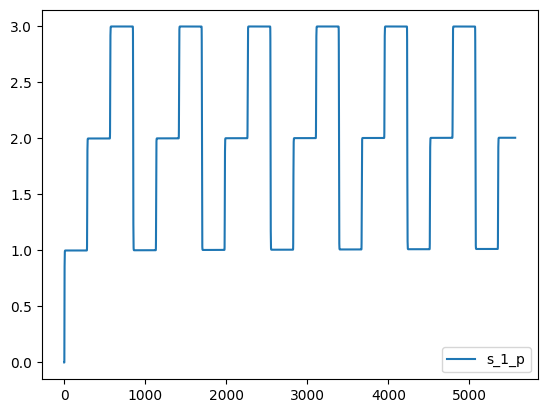

In [54]:
t_l1 = len(species_concentrations['s_1_p'])
time = np.linspace(0, t_l1-1, t_l1)
plt.plot(time, species_concentrations['s_1_p'], label='s_1_p')
# plt.plot(time, species_concentrations['s_2_p'], label='s_2_p')
# plt.plot(time, species_concentrations['s_1_n'], label='s_1_n')
# plt.plot(time, species_concentrations['s_2_n'], label='s_2_n')
# plt.plot(time, species_concentrations['y_p'], label='y_p')
# plt.plot(time, species_concentrations['y_n'], label='y_n')
plt.legend()
plt.show()

66.94396790459733
43.73741586423365
14.389660086885018
6.816997993469018


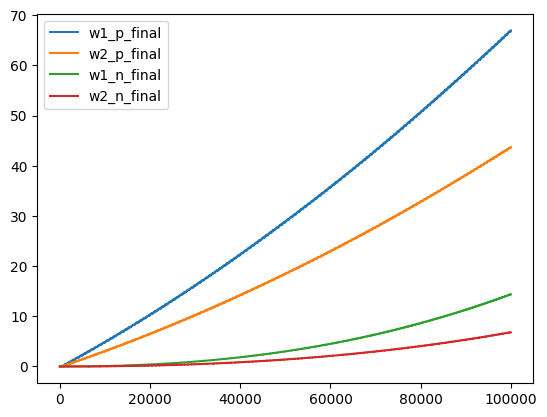

2.229660404347204 31.654037008988286


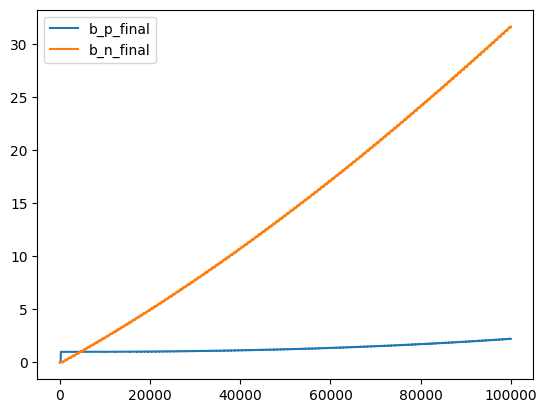

In [ ]:
# printing and plotting the final weights and bias
t_limit = t_l1
time = np.linspace(0,t_limit-1,t_limit)
for i in range(len(final_weights)):
    plt.plot(time, species_concentrations[final_weights[i]], label = final_weights[i])
    print(species_concentrations[final_weights[i]][-1])

plt.legend()
plt.show()

time = np.linspace(0,t_limit-1,t_limit)
plt.plot(time, species_concentrations['b_p_final'], label = 'b_p_final')
plt.plot(time, species_concentrations['b_n_final'], label = 'b_n_final')
print (species_concentrations['b_p_final'][-1], species_concentrations['b_n_final'][-1])
plt.legend()
plt.show()


In [ ]:
# final experimental weights and biases
w1_p = species_concentrations['w1_p_final'][-1]
w2_p = species_concentrations['w2_p_final'][-1]
w1_n = species_concentrations['w1_n_final'][-1]
w2_n = species_concentrations['w2_n_final'][-1]
b_p = species_concentrations['b_p_final'][-1]
b_n = species_concentrations['b_n_final'][-1]

w1 = w1_p - w1_n
w2 = w2_p - w2_n
b = b_p - b_n

print(w1, w2, b)

52.55430781771231 36.92041787076463 -29.424376604641083


In [ ]:
ans = []
for i in range(3):
    p = w1*X_train[i][0] + w2*X_train[i][1] + b
    q = p*y_train[i]

    if q >=1:
        ans.append(True)
    else:
        ans.append(False)

print(ans)

[True, True, True]


In [ ]:
print(X_train)

[[ 1.95673299  0.7872829 ]
 [-3.00844646  1.66529903]
 [ 2.18527396  1.80483269]]


In [ ]:
print(y_train)

[ 1 -1  1]


In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# Create an SVM model with a linear kernel (you can choose other kernels like 'rbf')
model = SVC(kernel='linear')

# Train the model
model.fit(X_train, y_train)


SVC(kernel='linear')

In [ ]:
print(model.class_weight_)

[1. 1.]


In [ ]:
weights = model.coef_
bias = model.intercept_

print("Weights:", weights)
print("Bias:", bias)

Weights: [[ 0.39059119 -0.06907008]]
Bias: [0.29009502]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# Create the SGDClassifier model with a linear kernel approximation
model = SGDClassifier(loss='hinge', max_iter=1, warm_start=True)

weights_history = []
bias_history = []

# Train the model and store the weights and bias after each iteration
for i in range(30):  # Assuming 100 iterations
    model.fit(X_train, y_train)
    weights_history.append(model.coef_.flatten().copy())
    bias_history.append(model.intercept_.copy())

weights_history = np.array(weights_history)
bias_history = np.array(bias_history)


/home/ameychoudhary4/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/ameychoudhary4/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/ameychoudhary4/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/ameychoudhary4/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/hom

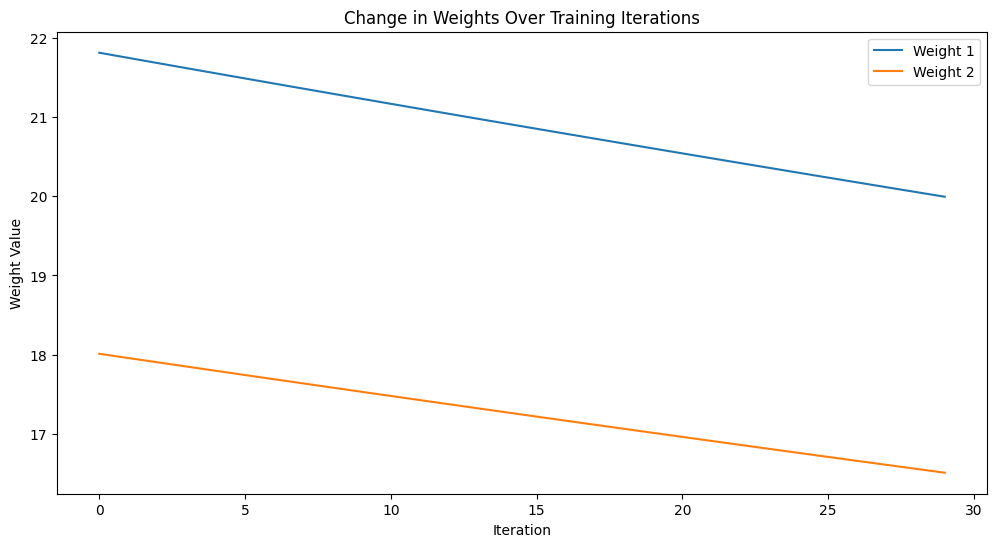

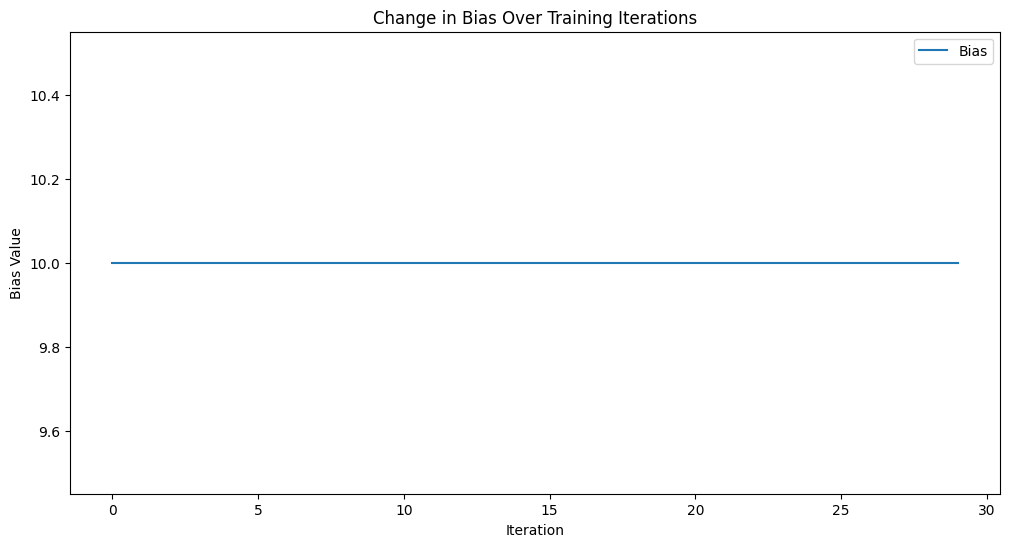

In [ ]:
# Plot the changes in weights
plt.figure(figsize=(12, 6))

# Plot each weight's change over iterations
for i in range(weights_history.shape[1]):
    plt.plot(weights_history[:, i], label=f'Weight {i+1}')

plt.title('Change in Weights Over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Weight Value')
plt.legend()
plt.show()

# Plot the change in bias
plt.figure(figsize=(12, 6))
plt.plot(bias_history, label='Bias')
plt.title('Change in Bias Over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Bias Value')
plt.legend()
plt.show()


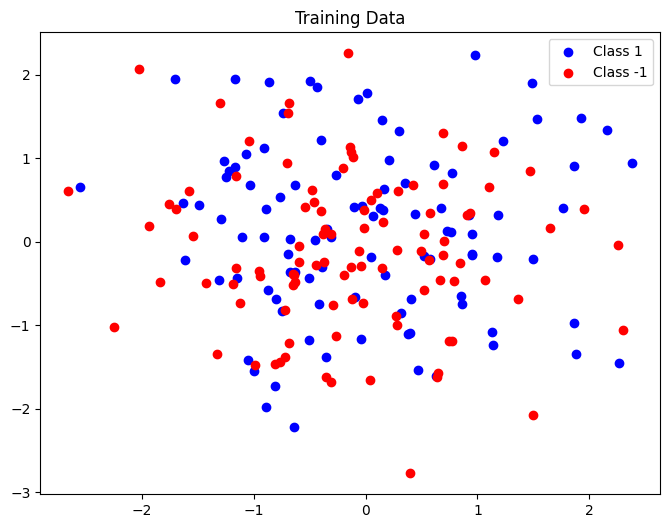

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some random data
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.ones(200)
y[100:] = -1

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[:100, 0], X[:100, 1], c='b', label='Class 1')  
plt.scatter(X[100:, 0], X[100:, 1], c='r', label='Class -1')
plt.legend()
plt.title('Training Data')
plt.show()

In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', C=1, decision_function_shape='ovr')
clf.fit(X, y)

SVC(C=1, kernel='linear')

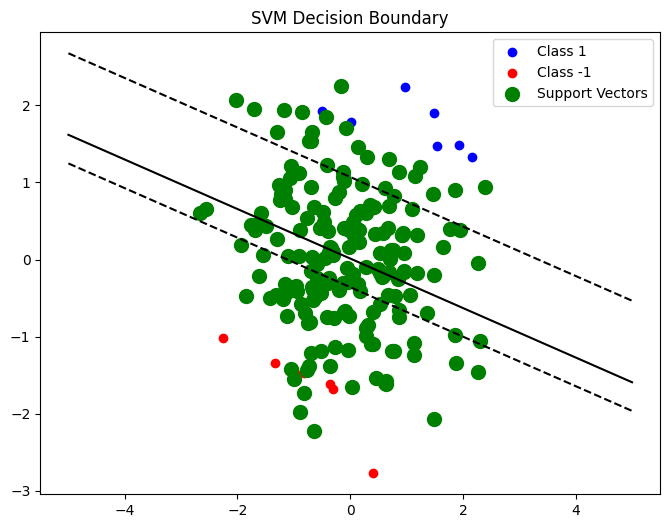

In [ ]:
# Get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]

# Plot the parallels to the separating hyperplane that pass through the support vectors
b = clf.support_vectors_[0]
yy_down = a * xx + (b[1] - a*b[0])
b = clf.support_vectors_[-1]
yy_up = a * xx + (b[1] - a*b[0])

# Plot the line, the points, and the nearest vectors to the plane
plt.figure(figsize=(8, 6))
plt.scatter(X[:100, 0], X[:100, 1], c='b', label='Class 1')
plt.scatter(X[100:, 0], X[100:, 1], c='r', label='Class -1')
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100, c='g', label='Support Vectors')
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')
plt.legend()
plt.title('SVM Decision Boundary')
plt.axis('tight')
plt.show()